We will check the performance of different feature maps so that we can see their effect when used in combination with classical models. This is part of the implicit model scheme outlines in [Quantum machine learning in feature Hilbert spaces](https://arxiv.org/pdf/1803.07128.pdf)

In [1]:
from sklearn.datasets import load_iris

iris = load_iris()

We will normalize the features so that they are in a comparable regime.

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(iris.data)

Given that the original dataset is a multiclass task we will make it binary to ease the work for now. It will also allow us to select the hardness of the problem, for dramatic effects. One important thing here is that we are going to split the dataset into *training* and *testing* datasets so that an unbiased metric can be obtained regarding model fitness. 

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

X_idx = np.where(iris.target < 2)
X = X_scaled[X_idx]
Y = iris.target[X_idx]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

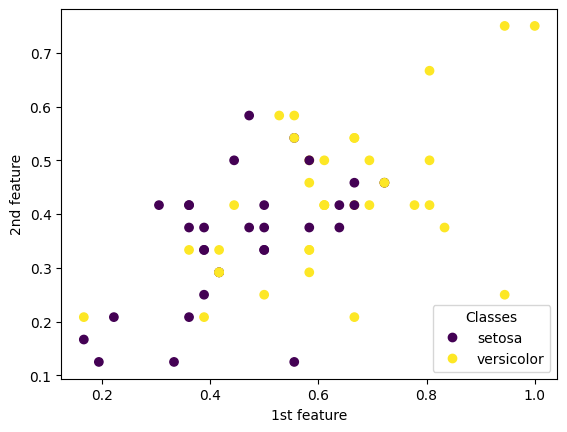

In [22]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
ax.set(xlabel="1st feature", ylabel="2nd feature")
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names[0:2], loc="lower right", title="Classes"
)

Now, knowing that sQUlearns provides with the means to easily build our quantum kernel, let's use those.

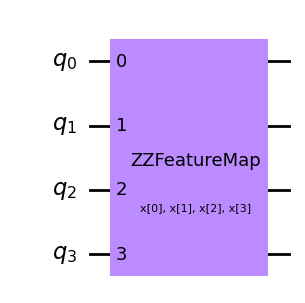

In [5]:
from qiskit.circuit.library import ZZFeatureMap

from squlearn.encoding_circuit import QiskitEncodingCircuit
from squlearn.kernel import FidelityKernel
from squlearn.util import Executor

features = X_scaled.shape[1]

# Qiskit FM
feature_map = ZZFeatureMap(feature_dimension=features, reps=1, entanglement="linear")
enc_circ = QiskitEncodingCircuit(feature_map)

q_kernel = FidelityKernel(
    encoding_circuit=enc_circ, executor=Executor("statevector_simulator"), parameter_seed=0
)
enc_circ.draw('mpl', style='clifford')

In [6]:
from squlearn.kernel import QSVC

qsvc = QSVC(quantum_kernel=q_kernel, probability=True)
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
     decision_function_shape='ovr', max_iter=-1, probability=True,
     quantum_kernel=<squlearn.kernel.matrix.fidelity_kernel.FidelityKernel object at 0x29d511890>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

QSVC is our Quantum Support Vector Classifier ready to be trained. The structure, optimization technique and other parameters have been set by default.

In [7]:
Z = qsvc.predict_proba(X_test)

Predict_proba function obtains the membership probability for each of the classes therefore, in order to get the selected class label we would need to obtain the position of the one with the highest probability.

In [8]:
import numpy as np

label = []
for elem in Z:
    label += [np.argmax(elem)]

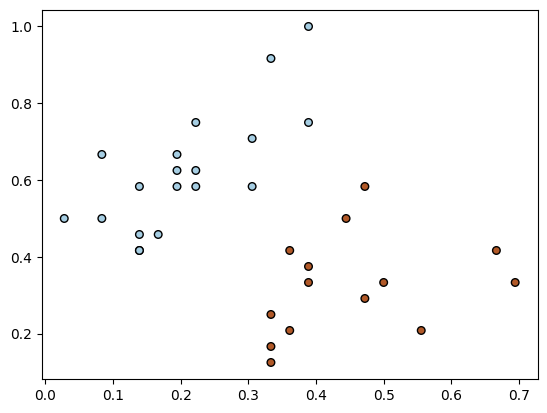

In [9]:
plt.scatter(X_test[:, 0], X_test[:, 1], s=30, c=label, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))

In [10]:
from sklearn.metrics import classification_report

print(classification_report(y_test, label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        14

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



Perfect! 100% accuracy. We build the perfect classifier...

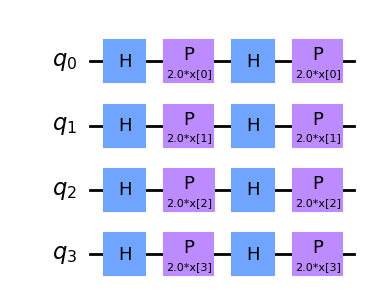

In [11]:
from qiskit.circuit.library import ZFeatureMap

feature_map = ZFeatureMap(feature_dimension=features, reps=2)
feature_map.decompose().draw('mpl', style='clifford')

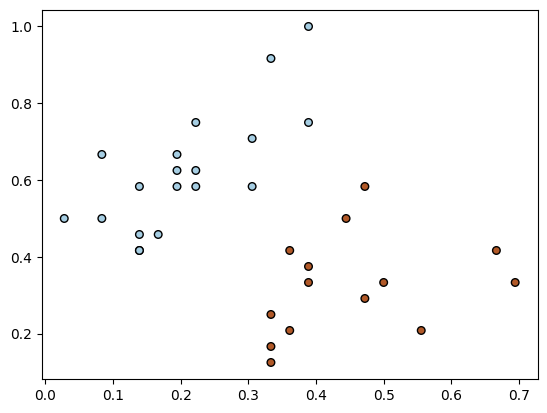

In [12]:
q_kernel = FidelityKernel(
    encoding_circuit=enc_circ, executor=Executor("statevector_simulator"), parameter_seed=0
)
qsvc = QSVC(quantum_kernel=q_kernel, probability=True)
qsvc.fit(X_train, y_train)

label = []
for elem in qsvc.predict_proba(X_test):
    label += [np.argmax(elem)]
plt.scatter(X_test[:, 0], X_test[:, 1], s=30, c=label, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))

In [13]:
print(classification_report(y_test, label))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        14

    accuracy                           1.00        33
   macro avg       1.00      1.00      1.00        33
weighted avg       1.00      1.00      1.00        33



Ok, probably it is not perfect. It is just that the exercise was too simple. Let's make it harder!

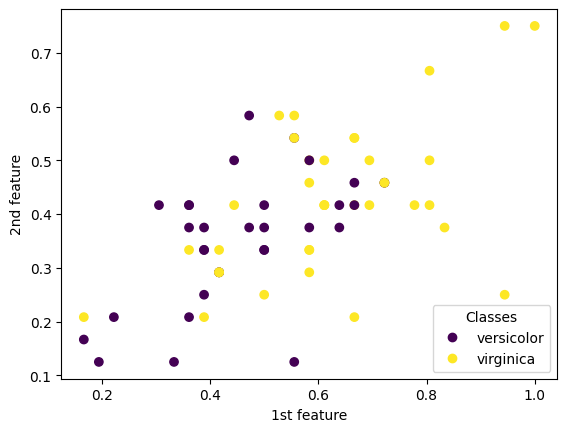

In [20]:
import numpy as np

X_idx = np.where(iris.target > 0)
X = X_scaled[X_idx]
Y = iris.target[X_idx] -1

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

_, ax = plt.subplots()
scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
ax.set(xlabel="1st feature", ylabel="2nd feature")
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names[1:], loc="lower right", title="Classes"
)

In [23]:
# Qiskit FM
feature_map = ZZFeatureMap(feature_dimension=features, reps=1, entanglement="linear")
enc_circ = QiskitEncodingCircuit(feature_map)

q_kernel = FidelityKernel(
    encoding_circuit=enc_circ, executor=Executor("statevector_simulator"), parameter_seed=0
)

qsvc = QSVC(quantum_kernel=q_kernel, probability=True)
qsvc.fit(X_train, y_train)

label = []
for elem in qsvc.predict_proba(X_test):
    label += [np.argmax(elem)]

print(classification_report(y_test, label))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.92      0.79      0.85        14

    accuracy                           0.88        33
   macro avg       0.89      0.87      0.87        33
weighted avg       0.88      0.88      0.88        33



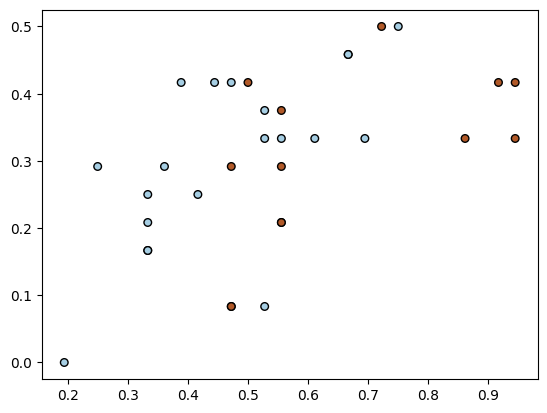

In [24]:
plt.scatter(X_test[:, 0], X_test[:, 1], s=30, c=label, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))

In [25]:
# Qiskit FM
feature_map = ZFeatureMap(feature_dimension=features, reps=1)
enc_circ = QiskitEncodingCircuit(feature_map)

q_kernel = FidelityKernel(
    encoding_circuit=enc_circ, executor=Executor("statevector_simulator"), parameter_seed=0
)

qsvc = QSVC(quantum_kernel=q_kernel, probability=True)
qsvc.fit(X_train, y_train)

label = []
for elem in qsvc.predict_proba(X_test):
    label += [np.argmax(elem)]

print(classification_report(y_test, label))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.93      0.93      0.93        14

    accuracy                           0.94        33
   macro avg       0.94      0.94      0.94        33
weighted avg       0.94      0.94      0.94        33



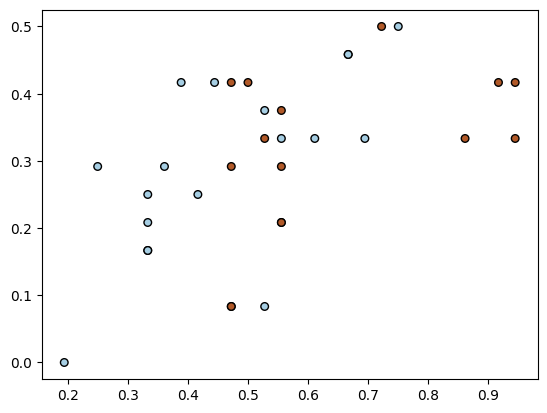

In [26]:
plt.scatter(X_test[:, 0], X_test[:, 1], s=30, c=label, cmap=plt.cm.Paired, edgecolors=(0, 0, 0))